In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Loading FashionMNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to 224x224
    transforms.ToTensor()            # Convert to tensor
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

### Preparing data for training with DataLoaders

In [3]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### ResNet18 Model Definition – Normal Convolution with CutMix

In [4]:
def conv3x3(in_planes, out_planes):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,padding=1, bias=False)

def conv1x1(in_planes, out_planes):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)  # Grayscale input
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], norm_layer, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], norm_layer, stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], norm_layer, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, norm_layer, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion),
                norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample, norm_layer)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def resnet18_cutmix(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [5]:
model = resnet18_cutmix(num_classes=10)

# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 11175370
Trainable parameters: 11175370


### Model Training

In [6]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
# Initialize and train the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = resnet18_cutmix(num_classes=10).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
earlystopper = EarlyStopper()

In [8]:
# Training function
def train(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    cutmix = v2.CutMix(num_classes=10)

    loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for images, labels in loop:
        images, labels = cutmix(images, labels)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        _, labels = labels.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    loss /= total
    acc = 100.0 * correct / total
    return loss, acc

In [9]:
best_val_acc = 0.0 
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train for several epochs
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, epoch)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion)
    
    # Store the values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(val_loss)
    test_accuracies.append(val_acc)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "resnet18_cutmix_fashionmnist.pth")
        print(f"Best model saved at epoch {epoch} with Val Acc: {val_acc:.2f}%")
    
    if earlystopper.early_stop(val_loss):
        break

[Epoch 1] Train Loss: 1.2643 | Train Acc: 69.32% | Val Loss: 0.4416 | Val Acc: 85.56%
Best model saved at epoch 1 with Val Acc: 85.56%


[Epoch 2] Train Loss: 1.1125 | Train Acc: 76.28% | Val Loss: 0.4065 | Val Acc: 87.39%
Best model saved at epoch 2 with Val Acc: 87.39%


[Epoch 3] Train Loss: 1.0826 | Train Acc: 77.58% | Val Loss: 0.3806 | Val Acc: 88.57%
Best model saved at epoch 3 with Val Acc: 88.57%


[Epoch 4] Train Loss: 1.0460 | Train Acc: 79.23% | Val Loss: 0.4018 | Val Acc: 87.80%


[Epoch 5] Train Loss: 1.0191 | Train Acc: 79.78% | Val Loss: 0.3229 | Val Acc: 90.43%
Best model saved at epoch 5 with Val Acc: 90.43%


[Epoch 6] Train Loss: 0.9995 | Train Acc: 80.41% | Val Loss: 0.3259 | Val Acc: 90.63%
Best model saved at epoch 6 with Val Acc: 90.63%


[Epoch 7] Train Loss: 0.9874 | Train Acc: 80.79% | Val Loss: 0.3079 | Val Acc: 91.61%
Best model saved at epoch 7 with Val Acc: 91.61%


[Epoch 8] Train Loss: 0.9837 | Train Acc: 80.66% | Val Loss: 0.3210 | Val Acc: 90.50%


[Epoch 9] Train Loss: 0.9693 | Train Acc: 80.78% | Val Loss: 0.3628 | Val Acc: 91.22%


[Epoch 10] Train Loss: 0.9548 | Train Acc: 81.28% | Val Loss: 0.3255 | Val Acc: 92.47%
Best model saved at epoch 10 with Val Acc: 92.47%


### Print Classification Results

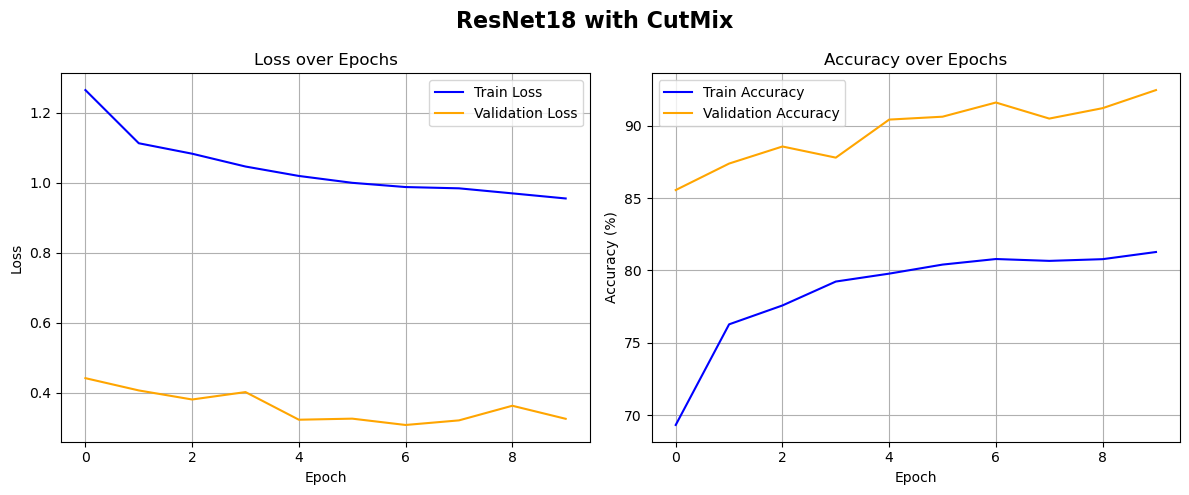

In [10]:
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.suptitle("ResNet18 with CutMix", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


In [11]:
# Load Best Model from checkpoint
model = torch.load("resnet18_cutmix_fashionmnist.pth", weights_only=False)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report_CutMix:")
print(classification_report(all_labels, all_preds, digits=4))



Classification Report_CutMix:
              precision    recall  f1-score   support

           0     0.8409    0.9090    0.8736      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8681    0.9280    0.8971      1000
           3     0.8729    0.9550    0.9121      1000
           4     0.9209    0.8730    0.8963      1000
           5     0.9850    0.9840    0.9845      1000
           6     0.8703    0.6910    0.7703      1000
           7     0.9531    0.9760    0.9644      1000
           8     0.9763    0.9890    0.9826      1000
           9     0.9776    0.9620    0.9698      1000

    accuracy                         0.9247     10000
   macro avg     0.9251    0.9247    0.9234     10000
weighted avg     0.9251    0.9247    0.9234     10000



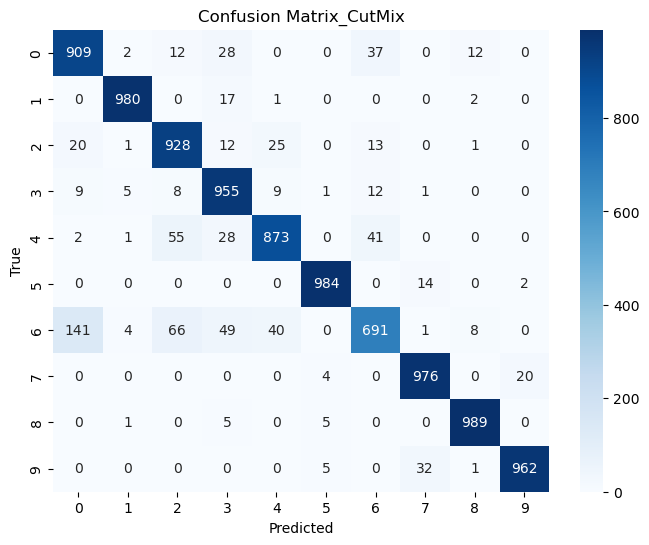

In [13]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix_CutMix")
plt.show()